In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
from scipy.optimize import minimize

## Group Assignment
### Team Number: [Number]
### Team Member Names: Arya Patel, Saihej Singh, Matthew Gong
### Team Strategy Chosen: RISKY

In [2]:
# Replace 'Tickers_Example.csv' with the actual ticker CSV file
ticker_file = 'Tickers_Example.csv'

# Read the CSV file into a pandas DataFrame with a single column
tickers_df = pd.read_csv(ticker_file, header=None, names=['Tickers'])

# Set the single column as the index
tickers_df.set_index('Tickers', inplace=True)

# Create an info cell for each ticker, saving time when filtering the tickers by volume and country.
info_column = {}
hist_column = {}
long_hist_column = {}
ticker_obj_lst = []

# Initilize dates that will outline the timeframe of stock data we analyze. 
long_start_date = "2018-10-31"
start_date = "2023-01-01"
end_date = "2023-10-31"

tickers_df = tickers_df[~tickers_df.index.duplicated(keep='first')] # Remove duplicate tickers.

# Add info to dict
for ticker in tickers_df.index:
    yf_ticker = yf.Ticker(ticker)
    info_column[ticker] = yf_ticker.fast_info
    hist_column[ticker] = yf_ticker.history(start=start_date, end=end_date)
    long_hist_column[ticker] = yf_ticker.history(start=long_start_date, end=end_date)
    print('.', end='')

# Create column for the info]
tickers_df['Info'] = pd.Series(info_column)
tickers_df['History'] = pd.Series(hist_column)
tickers_df['Long History'] = pd.Series(long_hist_column)
tickers_df

# Takes around 5 seconds to start

....

AGN: No timezone found, symbol may be delisted
AGN: No timezone found, symbol may be delisted


............

CELG: No timezone found, symbol may be delisted
CELG: No timezone found, symbol may be delisted


.....

MON: No timezone found, symbol may be delisted
MON: No timezone found, symbol may be delisted


.........

RTN: No timezone found, symbol may be delisted
RTN: No timezone found, symbol may be delisted


..........

,Info,History,Long History
Tickers,,,
AAPL,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
ABBV,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
ABT,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open Hig...
ACN,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
AGN,"lazy-loading dict with keys = ['currency', 'da...","Empty DataFrame Columns: [Open, High, Low, Clo...","Empty DataFrame Columns: [Open, High, Low, Clo..."
AIG,"lazy-loading dict with keys = ['currency', 'da...",Open Hig...,Open Hig...
AMZN,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
AXP,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...
BA,"lazy-loading dict with keys = ['currency', 'da...",Open H...,Open H...


In [3]:
minVolume = 150000
allowed_currencies = ["USD", "CAD"]
threshold_day = 18
days_in_month = []

CAD_stocks = []
USD_stocks = []
all_stocks = []

for ticker in tickers_df.index:
    if tickers_df['History'][ticker].empty:
        print(ticker, "is delisted.")
    else:
        group_months = tickers_df["History"][ticker].reset_index().groupby(pd.Grouper(key="Date", freq='M'))
        dfs = [group for _, group in group_months]
        for i, df in enumerate(dfs):
            #recombine all the months with more trading days than set threshold
            if len(df.index) >= threshold_day:
                days_in_month.append(len(df.index))

        if tickers_df['Info'][ticker]['currency'] not in allowed_currencies:
            print(ticker, "is not in USD or CAD")
        elif tickers_df['History'][ticker]['Volume'].mean() * (np.mean(days_in_month)) < minVolume:
            print(ticker, "only has a volume of", tickers_df.iloc['Info'][ticker]['lastVolume'], "and average days of", np.mean(days_in_month))
        else:
            all_stocks.append(ticker)
            if tickers_df['Info'][ticker]['currency'] == 'USD':
                USD_stocks.append(ticker)
            elif tickers_df['Info'][ticker]['currency'] == 'CAD':
                CAD_stocks.append(ticker)
                                
print("\nValid CAD Stocks:\n",CAD_stocks)
print("\nValid USD Stocks:\n",USD_stocks)
print("\nValid All Valid Stocks:\n", all_stocks)

AGN is delisted.
CELG is delisted.
MON is delisted.
RTN is delisted.

Valid CAD Stocks:
 ['RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO']

Valid USD Stocks:
 ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']

Valid All Valid Stocks:
 ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'KO', 'LLY', 'LMT', 'MO', 'MRK', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RY.TO', 'SHOP.TO', 'T.TO', 'TD.TO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB']


In [4]:
stock_stds = []
stocks_df = pd.DataFrame()

##Retreiving CADUSD currency conversion data
exchange = yf.Ticker('CADUSD=x')
exchange_hist = exchange.history(start=start_date, end=end_date)

exchange_hist.index = pd.to_datetime(exchange_hist.index)
exchange_hist.index = exchange_hist.index.date

##Debugging
# print(tickers_df['History']['AAPL']['Close'].iloc[0])
# print(exchange_hist.Close.iloc[1])
# print(tickers_df['History']['AAPL']['Close'].iloc[0] * (1/exchange_hist.Close.iloc[1]))

##Creating dataframe for all stocks closing prices in CAD
for ticker in all_stocks:
    currCurrency = tickers_df['Info'][ticker]['currency']
    currClose = tickers_df['History'][ticker]['Close']
    
    ##changing stock index to match with CADUSD conversion index
    currClose.index = pd.to_datetime(currClose.index)
    currClose.index = currClose.index.date
    
    ##make sure all stocks are priced in CAD
    if currCurrency == "USD":                                       
        stocks_df[ticker] = currClose * (1/exchange_hist.Close)
    else:
        stocks_df[ticker] = currClose
        
    ##Making list of 
    stocks_df = stocks_df.dropna()
    
stocks_df
##reason to keep all stocks in the same currency is to increase accuracy of the correlation calculations

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
2023-01-03,168.639803,211.621955,145.665514,360.714647,83.711194,116.363344,196.572718,264.929315,44.415907,369.659044,...,142.464865,122.739281,48.790001,25.214357,84.689217,214.563573,695.157322,276.074070,228.572671,57.969782
2023-01-04,171.825503,215.140095,149.087180,362.538230,85.669408,116.421281,202.849763,278.459358,45.635063,370.308280,...,149.477471,123.832161,50.610001,25.520916,85.790459,224.286735,681.944918,280.644092,232.919637,60.282250
2023-01-05,167.653603,211.907267,146.484501,349.084947,84.022259,112.088154,195.258901,276.431070,44.912033,366.241823,...,144.596183,123.467865,48.830002,25.492176,84.384216,218.257955,653.136830,268.617198,225.459282,58.984097
2023-01-06,174.786446,217.070924,149.331011,359.337031,85.871862,116.723626,201.356783,288.825880,45.611842,378.660220,...,153.292806,125.040092,49.560001,25.884954,84.345154,230.288889,656.813348,281.984519,233.373985,60.142445
2023-01-09,173.887198,208.759965,147.720630,362.036668,84.185858,117.369912,199.810640,280.217986,44.509442,369.091829,...,150.921802,125.970009,49.810001,25.827475,84.081490,230.151097,650.852846,278.666550,234.768279,59.975380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,237.100988,200.276445,129.780668,405.302802,81.953050,175.979357,197.689320,249.623493,34.864609,345.100783,...,149.738504,109.029999,71.870003,22.360001,76.830002,199.284689,718.646268,281.216554,202.030681,42.968202
2023-10-25,234.809448,199.610478,128.580154,402.189148,83.768794,166.809285,197.219453,244.229456,35.109788,339.032764,...,143.984486,109.110001,66.900002,22.280001,76.919998,193.072336,728.593420,282.005123,199.568144,42.997469
2023-10-26,230.053533,200.418114,129.719665,403.099924,83.990649,165.041283,197.850774,247.196144,36.053178,332.760333,...,145.786241,110.209999,64.529999,22.320000,77.410004,196.970043,729.290041,279.149871,188.561638,43.851816
2023-10-27,232.073362,191.917889,128.262986,400.661261,82.234739,176.460030,195.205627,248.223765,34.769838,323.965929,...,147.063840,108.470001,64.349998,22.010000,76.160004,195.910134,724.765275,278.656005,184.098169,42.326094


In [5]:
##std-dataframe function

def getStds(dataframe):
    
    ##define variables
    stock_stds = []
    stock_list = sorted(dataframe)
    
    ##append each stock's percent std to a list
    for stock in stock_list:
        currPctChange = dataframe[stock].pct_change() * 100
        stock_stds.append(currPctChange.std())
        
    ##make dataframe with stock names as indexes with their associated std vlaue   
    stock_stds = pd.DataFrame(stock_stds, columns=['stds'])
    stock_stds.index = stock_list
    
    return stock_stds
    
    
stds = getStds(stocks_df)
stds

,stds
AAPL,1.340555
ABBV,1.339443
ABT,1.310785
ACN,1.503597
AIG,1.798249
AMZN,2.207021
AXP,1.714514
BA,1.801327
BAC,1.666901
BIIB,1.344842


## Compare highest std to lowest std stock graphs and analyze why it is useful:

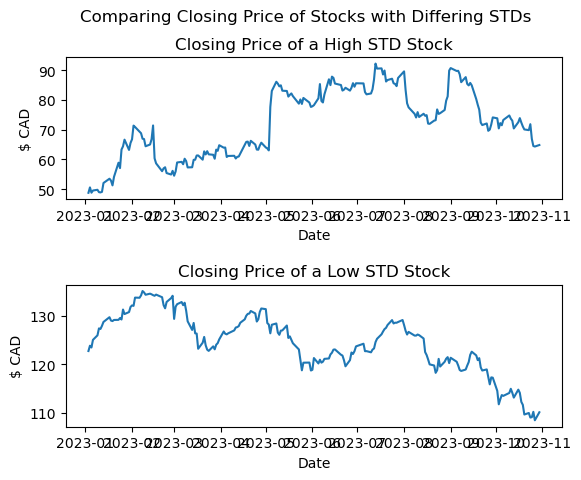

In [6]:
maxStd = max(stds['stds'])
minStd = min(stds['stds'])

maxStdStock = stds[stds['stds']==maxStd].index.values[0]
minStdStock = stds[stds['stds']==minStd].index.values[0]

##Graphs
fig, ((ax1), (ax2)) = plt.subplots(2, 1)

## Overall title
fig.suptitle('Comparing Closing Price of Stocks with Differing STDs')

## Subplot titles
ax1.set_title("Closing Price of a High STD Stock")
ax2.set_title("Closing Price of a Low STD Stock")

# Formatting subplots
plt.subplots_adjust(hspace=0.6)


# Subplot 1 
ax1.plot(stocks_df.index, stocks_df[maxStdStock])

# Subplot 2
ax2.plot(stocks_df.index, stocks_df[minStdStock])

# Labels
ax1.set_ylabel("$ CAD")
ax2.set_ylabel("$ CAD")

ax1.set_xlabel("Date")
ax2.set_xlabel("Date")

plt.show()

In [7]:
marketTicker = yf.Ticker("^GSPC")
marketHist = marketTicker.history(start=long_start_date, end=end_date)

beta = {}

def beta_volatility(ticker):
    prices = pd.DataFrame(tickers_df["Long History"][ticker]["Close"])
    prices.columns = [ticker]
    prices["Market"] = marketHist['Close']

    monthly_change = prices.resample("M").ffill().pct_change()
    monthly_change = monthly_change.drop(index=monthly_change.index[0])

    return (monthly_change.cov()/monthly_change["Market"].var()).iat[0, 1]


for ticker in all_stocks:
    beta[ticker] = abs(beta_volatility(ticker))

sorted_BTlist = sorted(beta.items(), key=lambda x:x[1], reverse=True)
sorted_BTlist

[('SHOP.TO', 1.8105683661552794),
 ('C', 1.5566631187814812),
 ('BA', 1.4762120488587196),
 ('BAC', 1.3851002778781587),
 ('PYPL', 1.3792816900669551),
 ('AAPL', 1.303633566056742),
 ('BLK', 1.2835915720157947),
 ('ACN', 1.230449969588595),
 ('QCOM', 1.2167447096422914),
 ('AXP', 1.2146616792737193),
 ('AMZN', 1.1719942897819302),
 ('UPS', 1.1049473704732626),
 ('UNP', 1.1025175434423442),
 ('BK', 1.0953391127097452),
 ('CAT', 1.0879437562622194),
 ('AIG', 1.0351018811128943),
 ('USB', 1.0267299192044435),
 ('TXN', 1.0168282607782482),
 ('PM', 0.7766930063338162),
 ('ABT', 0.6933946140979159),
 ('MO', 0.6535231724631422),
 ('TD.TO', 0.6386755902464739),
 ('UNH', 0.6321132366092984),
 ('PFE', 0.6305322478357026),
 ('LMT', 0.5987254084397886),
 ('KO', 0.5908106023441815),
 ('PEP', 0.5726416919292886),
 ('RY.TO', 0.5664457378097226),
 ('ABBV', 0.5070217837117889),
 ('PG', 0.47479153427738485),
 ('CL', 0.46066639403782067),
 ('T.TO', 0.4596698386812666),
 ('BMY', 0.3853921731453149),
 ('MR

In [8]:
betaList = list(sorted_BTlist)
betaList_vals = []
betaList_stocks = []

for i in range(len(betaList)):
    betaList_stocks.append(betaList[i][0])
    betaList_vals.append(betaList[i][1])
    
betaList_stocks

['SHOP.TO',
 'C',
 'BA',
 'BAC',
 'PYPL',
 'AAPL',
 'BLK',
 'ACN',
 'QCOM',
 'AXP',
 'AMZN',
 'UPS',
 'UNP',
 'BK',
 'CAT',
 'AIG',
 'USB',
 'TXN',
 'PM',
 'ABT',
 'MO',
 'TD.TO',
 'UNH',
 'PFE',
 'LMT',
 'KO',
 'PEP',
 'RY.TO',
 'ABBV',
 'PG',
 'CL',
 'T.TO',
 'BMY',
 'MRK',
 'LLY',
 'BIIB']

In [9]:
stocks_corr = stocks_df.corr()

# Create a dictionary of stock pairs and their correlation coefficients
correlation_dict = {}
for i in range(len(stocks_corr.columns)):
    for j in range(i + 1, len(stocks_corr.columns)):
        stock_pair = (stocks_corr.columns[i], stocks_corr.columns[j])
        correlation_coefficient = stocks_corr.iloc[i, j]
        correlation_dict[stock_pair] = correlation_coefficient

# Sort the dictionary based on correlation coefficients
sorted_corrPairsDict = dict(sorted(correlation_dict.items(), key=lambda item: item[1], reverse=True))

stocks_corr

,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
AAPL,1.000000,-0.412003,-0.236540,0.765406,-0.098706,0.859363,0.028720,0.146018,-0.660112,-0.143137,...,-0.335481,-0.500902,0.871692,-0.589936,-0.414228,-0.166168,0.126990,0.347555,-0.301694,-0.693244
ABBV,-0.412003,1.000000,-0.159572,-0.308239,-0.044701,-0.326484,-0.296632,-0.063601,0.054739,-0.272347,...,-0.010159,0.064396,-0.619952,0.070569,0.029613,-0.096470,0.430204,0.099806,0.146268,0.182809
ABT,-0.236540,-0.159572,1.000000,-0.240977,-0.033423,-0.280658,0.034817,0.385251,0.465346,0.494454,...,0.127127,0.617423,0.014768,0.495271,0.478486,0.315726,-0.400822,0.026774,0.391726,0.281650
ACN,0.765406,-0.308239,-0.240977,1.000000,0.393938,0.917357,-0.051855,0.226013,-0.362580,-0.361674,...,-0.262088,-0.598875,0.706022,-0.791494,-0.143366,-0.253021,0.258312,0.623629,-0.511331,-0.337330
AIG,-0.098706,-0.044701,-0.033423,0.393938,1.000000,0.279757,-0.080478,-0.017821,0.406785,-0.484972,...,-0.007211,-0.205083,-0.022311,-0.530876,0.540119,-0.435777,0.336219,0.578206,-0.522299,0.486618
AMZN,0.859363,-0.326484,-0.280658,0.917357,0.279757,1.000000,-0.108879,0.167480,-0.519679,-0.372002,...,-0.400675,-0.651628,0.786403,-0.813472,-0.254313,-0.363119,0.258587,0.597491,-0.562093,-0.493526
AXP,0.028720,-0.296632,0.034817,-0.051855,-0.080478,-0.108879,1.000000,0.423365,0.472461,0.023059,...,0.649931,0.548250,0.095058,0.204307,0.395757,0.604372,-0.494091,-0.063453,0.552565,0.411628
BA,0.146018,-0.063601,0.385251,0.226013,-0.017821,0.167480,0.423365,1.000000,0.331519,0.017283,...,0.286680,0.380515,0.208805,-0.026178,0.343799,0.513982,-0.351619,0.490339,0.457462,0.280385
BAC,-0.660112,0.054739,0.465346,-0.362580,0.406785,-0.519679,0.472461,0.331519,1.000000,0.030572,...,0.633280,0.727113,-0.442652,0.367238,0.873504,0.390425,-0.290293,0.084127,0.427205,0.947259
BIIB,-0.143137,-0.272347,0.494454,-0.361674,-0.484972,-0.372002,0.023059,0.017283,0.030572,1.000000,...,-0.045769,0.387730,0.050838,0.702429,-0.078764,0.230525,-0.347801,-0.553590,0.287933,-0.192044


In [10]:
sorted_corrPairsDict

{('BK', 'USB'): 0.9497087945778191,
 ('BAC', 'USB'): 0.9472594146881743,
 ('ACN', 'AMZN'): 0.9173569855333552,
 ('BMY', 'PFE'): 0.9091023416372501,
 ('BMY', 'T.TO'): 0.8971128991575834,
 ('AMZN', 'LLY'): 0.8906843382694813,
 ('BAC', 'BK'): 0.8850726751105474,
 ('C', 'RY.TO'): 0.8832896202286458,
 ('BAC', 'TD.TO'): 0.8735037926720289,
 ('AAPL', 'SHOP.TO'): 0.8716919815925448,
 ('AAPL', 'AMZN'): 0.8593625088788798,
 ('TXN', 'UPS'): 0.8586654581302243,
 ('PYPL', 'RY.TO'): 0.8567695292987775,
 ('BMY', 'PYPL'): 0.8500689066058076,
 ('TD.TO', 'USB'): 0.841344704721414,
 ('ACN', 'LLY'): 0.8226562610268772,
 ('CAT', 'UNP'): 0.8226188974492742,
 ('PFE', 'PYPL'): 0.813192435233647,
 ('C', 'PYPL'): 0.805702559814698,
 ('KO', 'PEP'): 0.7985860099843848,
 ('BMY', 'C'): 0.7970325175173975,
 ('BMY', 'RY.TO'): 0.7931771251955607,
 ('PYPL', 'UPS'): 0.7864928733463814,
 ('AMZN', 'SHOP.TO'): 0.7864033465013137,
 ('RY.TO', 'UPS'): 0.7777792938438993,
 ('BK', 'TD.TO'): 0.772927607733827,
 ('PYPL', 'T.TO'):

In [11]:
betaList_stocks

allPorts = []
allPortCorrAvgs = []

##for the top 10 highest beta stocks
for stock in betaList_stocks:
    
    tempPort = [stock]
    tempCorr=0
    tempCorrSum = 0
    tempCorrAvg = []
   
    ##for each possible correlation given all the stocks
    ##correlations are sorted from highest to lowest
    for item in sorted_corrPairsDict:   
           
        if (len(tempPort) >= 10):
            allPorts.append(tempPort)
            tempCorrAvg = tempCorrSum/9
            allPortCorrAvgs.append(tempCorrAvg)
            
            break;
            ##then goes to the next highest beta stock
            
        if (item[0]==stock):
            tempPort.append(item[1])
            tempCorr = stocks_corr._get_value(stock, item[1])
            tempCorrSum += tempCorr

        elif(item[1]==stock):
            tempPort.append(item[0])
            tempCorr = stocks_corr._get_value(stock, item[0])
            tempCorrSum += tempCorr

        
##REMOVE DUPLICATE PORTFOLIOS

        
      
##general checks
beta_corr_sum = []
compare = pd.DataFrame()     

for i in range(len(allPorts)):
    beta_corr_sum.append(allPortCorrAvgs[i] + betaList_vals[i])
               
compare['sum'] = beta_corr_sum
compare['beta'] = betaList_vals
compare['avg correlation'] = allPortCorrAvgs

  
highestCorr = max(allPortCorrAvgs)
bestPortIndex = allPortCorrAvgs.index(highestCorr)
bestPortfolio = allPorts[bestPortIndex]
            
print("All Portfolios: \n", allPorts, "\n")
print("All Correlation Averages (to the main stock): \n", allPortCorrAvgs, "\n")
print("Most Correlated Portfolio: \n", bestPortfolio, "\n")
print("Avg Correlation of Most Correlated Portfolio: \n", max(allPortCorrAvgs), "\n")

compare


##THERE ARE DUPLICATE PORTFOLIOS GET RID OF THEM
##ASK GPT 

All Portfolios: 
 [['SHOP.TO', 'AAPL', 'AMZN', 'ACN', 'LLY', 'PEP', 'PG', 'UNP', 'CAT', 'BA'], ['C', 'RY.TO', 'PYPL', 'BMY', 'T.TO', 'BAC', 'PFE', 'UPS', 'QCOM', 'BK'], ['BA', 'TXN', 'BLK', 'UNP', 'UPS', 'AXP', 'ABT', 'KO', 'RY.TO', 'PEP'], ['BAC', 'USB', 'BK', 'TD.TO', 'BLK', 'C', 'RY.TO', 'PYPL', 'PFE', 'PM'], ['PYPL', 'RY.TO', 'BMY', 'PFE', 'C', 'UPS', 'T.TO', 'QCOM', 'BAC', 'TXN'], ['AAPL', 'SHOP.TO', 'AMZN', 'ACN', 'LLY', 'PG', 'PEP', 'UNP', 'CAT', 'BA'], ['BLK', 'BAC', 'TD.TO', 'USB', 'BK', 'ABT', 'PM', 'QCOM', 'PYPL', 'RY.TO'], ['ACN', 'AMZN', 'LLY', 'AAPL', 'SHOP.TO', 'CAT', 'UNP', 'PG', 'AIG', 'UNH'], ['QCOM', 'PYPL', 'BK', 'AXP', 'USB', 'BAC', 'TXN', 'C', 'UPS', 'RY.TO'], ['AXP', 'QCOM', 'TXN', 'C', 'UPS', 'RY.TO', 'BK', 'BAC', 'PYPL', 'BA'], ['AMZN', 'ACN', 'LLY', 'AAPL', 'SHOP.TO', 'CAT', 'UNP', 'PG', 'AIG', 'UNH'], ['UPS', 'TXN', 'PYPL', 'RY.TO', 'BMY', 'C', 'LMT', 'T.TO', 'QCOM', 'KO'], ['UNP', 'CAT', 'ACN', 'AMZN', 'LLY', 'AIG', 'BA', 'PG', 'AAPL', 'UNH'], ['BK', 'USB', 

,sum,beta,avg correlation
0,2.301652,1.810568,0.491084
1,2.292631,1.556663,0.735968
2,1.907119,1.476212,0.430907
3,2.161666,1.385100,0.776565
4,2.154521,1.379282,0.775239
5,1.839185,1.303634,0.535551
6,1.886897,1.283592,0.603305
7,1.851399,1.230450,0.620949
8,1.855975,1.216745,0.639231
9,1.747393,1.214662,0.532731


In [12]:
all_returns = (stocks_df.pct_change() * 100).dropna()
filtered_returns = all_returns[bestPortfolio]
filtered_returns

,BAC,USB,BK,TD.TO,BLK,C,RY.TO,PYPL,PFE,PM
2023-01-04,2.744865,3.989093,3.331978,1.300333,2.245391,3.448295,0.890408,5.054290,-1.374283,0.779184
2023-01-05,-1.584375,-2.153458,-1.860296,-1.639159,-4.204516,-1.823181,-0.294185,-3.184692,-2.306774,-1.781602
2023-01-06,1.558177,1.963831,2.130852,-0.046291,5.825911,1.759200,1.273390,0.831564,3.106007,3.217668
2023-01-09,-2.416916,-0.277782,-0.527027,-0.312602,1.092859,-0.437941,0.743695,-0.142321,-5.842499,-2.058907
2023-01-10,0.367683,-0.201941,-0.578111,-0.116145,0.259076,1.054151,1.141556,0.777509,-1.895220,-0.416096
...,...,...,...,...,...,...,...,...,...,...
2023-10-24,-0.496485,0.309610,0.568336,-2.189690,-0.486060,-0.003072,-0.853323,1.370641,-1.433853,-0.204693
2023-10-25,0.703230,0.068113,0.580175,0.117137,-0.220260,-0.437261,0.073376,-4.701810,1.377610,-0.496270
2023-10-26,2.686972,1.986972,2.118989,0.637033,0.180409,2.345237,1.008156,0.953295,1.851621,0.089071
2023-10-27,-3.559576,-3.479267,-1.083862,-1.614778,-1.401662,-2.717969,-1.578802,-2.549723,-3.292003,-2.418529


In [13]:
# Calculate the covariance matrix
covariance_matrix = filtered_returns.cov()
covariance_matrix

,BAC,USB,BK,TD.TO,BLK,C,RY.TO,PYPL,PFE,PM
BAC,2.778559,3.168846,1.960981,1.100809,1.382206,2.158332,0.845860,1.249507,0.637064,0.756498
USB,3.168846,6.713315,3.114089,1.554688,2.000139,2.835924,1.201051,1.962227,0.879504,1.160864
BK,1.960981,3.114089,2.666646,0.899521,1.317399,2.041533,0.731563,1.066652,0.382161,0.778485
TD.TO,1.100809,1.554688,0.899521,1.154927,0.702567,0.989847,0.620076,0.975425,0.325886,0.383372
BLK,1.382206,2.000139,1.317399,0.702567,1.831779,1.297623,0.631767,1.377413,0.455885,0.520056
C,2.158332,2.835924,2.041533,0.989847,1.297623,2.663533,0.725251,1.102629,0.374969,0.753791
RY.TO,0.845860,1.201051,0.731563,0.620076,0.631767,0.725251,0.847628,0.793007,0.160894,0.331185
PYPL,1.249507,1.962227,1.066652,0.975425,1.377413,1.102629,0.793007,5.167671,0.636967,0.614557
PFE,0.637064,0.879504,0.382161,0.325886,0.455885,0.374969,0.160894,0.636967,2.010492,0.396613
PM,0.756498,1.160864,0.778485,0.383372,0.520056,0.753791,0.331185,0.614557,0.396613,1.245019


## Weightage Optimizaiton Algorithm

***Algorithm Used:***
- The method specified in the code is 'SLSQP', which stands for Sequential Least Squares Programming. This is an advanced mathematical technique used for optimization problems, especially those with constraints (like your maximum and minimum weight limits for each stock).

***Efficiency:***
- Rather than brute-forcing every possible combination of weights (which would be incredibly time-consuming and computationally expensive, especially with a large number of stocks), SLSQP uses mathematical methods to navigate towards the optimal solution more efficiently. It makes educated guesses about which direction to move in the "solution space" (the range of all possible answers) to find the best solution.

***How It Works:***
- *Starting Point:*
    - The algorithm begins with your initial_weight_guess and evaluates how good that guess is (i.e., how risky the portfolio is with those weights).
- *Iterative Improvement:*
    - Based on this evaluation, the algorithm makes adjustments to the weights and checks if these new weights make the portfolio riskier. It continues this process, making further adjustments and evaluations.
- *Considering Constraints:*
    - Throughout this process, it also ensures that the constraints you've set (like the total weight being 1, and each stock's weight within your set minimum and maximum) are always met.
- *Finding the Optimum:*
    - The algorithm stops this iterative process once it reaches a point where making further changes doesn't significantly improve the riskiness of the portfolio, or it meets other criteria for stopping (like running a certain number of iterations or reaching a computational time limit).

***Outcome:***
- *Result:*
    - The end result is a set of weights for each stock in your portfolio that are optimized for maximum risk, within the bounds of your constraints.
- *Not Exhaustive:*
    - It's important to note that while the solution is usually very good, the algorithm doesn't guarantee a perfect solution in every case, especially for very complex or unusual problems. However, it's generally very effective for problems like portfolio optimization.

In simple terms, think of it as a very smart system that tries out different combinations of how much money to put in each stock, but it does so in a clever way that doesn't require checking every single possibility. It keeps tweaking the amounts until it finds a combination that makes your portfolio as risky as you want, without breaking any of your rules.

In [14]:
# Define the maximum and minimum weight each stock can have in the portfolio
max_stock_weight = 0.20  # Maximum weight (20%)
min_stock_weight = 0.05  # Minimum weight (5%)

# Function to calculate the risk (volatility) of the portfolio
def calculate_portfolio_volatility(stock_weights, stock_returns):
    """
    Calculate the volatility of a portfolio based on stock weights and returns.
    
    :param stock_weights: A list of weights representing the fraction of the total portfolio value
                          held in each stock.
    :param stock_returns: A DataFrame containing the historical returns of each stock.
    :return: The volatility (standard deviation) of the portfolio's returns.
    """
    # Calculate expected portfolio return as a weighted average of individual stock returns
    expected_portfolio_return = np.dot(stock_weights, stock_returns.mean())
    
    # Calculate portfolio volatility as the square root of the weighted sum of covariances
    portfolio_variance = np.dot(stock_weights.T, np.dot(stock_returns.cov(), stock_weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    return portfolio_volatility

# Function to be minimized by the optimizer
def objective_function(stock_weights, stock_returns):
    """
    The objective function to be minimized by the optimizer. It returns the negative of the
    portfolio volatility, as the goal is to maximize volatility.

    :param stock_weights: A list of weights for each stock in the portfolio.
    :param stock_returns: A DataFrame of historical returns for each stock.
    :return: Negative of the portfolio's volatility.
    """
    return -calculate_portfolio_volatility(stock_weights, stock_returns)

# Set constraints and bounds for the optimization
total_weight_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Sum of weights must be 1
weight_bounds = [(min_stock_weight, max_stock_weight) for _ in range(len(filtered_returns.columns))]  # Bounds for each stock (between 5% to 20%)

# Initial guess for the stock weights (evenly distributed)
initial_weight_guess = [1 / len(filtered_returns.columns)] * len(filtered_returns.columns)

# Perform the optimization to find the best stock weights
optimized_portfolio = minimize(objective_function, initial_weight_guess, args=(filtered_returns,), method='SLSQP', bounds=weight_bounds, constraints=total_weight_constraint)

# Extract the optimized weights for each stock
optimized_stock_weights = optimized_portfolio.x

optimized_stock_weights

array([0.2 , 0.2 , 0.2 , 0.05, 0.05, 0.1 , 0.05, 0.05, 0.05, 0.05])

## Making Final Dataframes and Portfolio

In [22]:
Portfolio_Final = pd.DataFrame()
Portfolio_Final['Ticker'] = bestPortfolio
Portfolio_Final.index += 1
Portfolio_Final

,Ticker
1,BAC
2,USB
3,BK
4,TD.TO
5,BLK
6,C
7,RY.TO
8,PYPL
9,PFE
10,PM


In [23]:
# List of stock tickers: bestPortfolio

# Initialize a dictionary to hold each stock's respective price
closing_price = []

# Fetch the closing price for each stock and store it in the dictionary
for ticker in bestPortfolio:
    stock = yf.Ticker(ticker)
    hist = stock.history(period="1d")  # Fetches the latest available day's data
    closing_price.append(hist['Close'].iloc[-1]) # Get the last closing price

Portfolio_Final['Price'] = closing_price
Portfolio_Final

,Ticker,Price
1,BAC,29.730000
2,USB,37.200001
3,BK,47.349998
4,TD.TO,83.349998
5,BLK,730.099976
6,C,45.230000
7,RY.TO,118.959999
8,PYPL,55.759998
9,PFE,30.500000
10,PM,94.339996


In [24]:
# List of stock tickers: bestPortfolio

# Initialize a dictionary to hold each stock's respective currency denomination
currencies = []

# Fetch the currency for each stock and store it in the dictionary
for ticker in bestPortfolio:
    currencies.append(tickers_df['Info'][ticker]['currency'])

Portfolio_Final['Currency'] = currencies
Portfolio_Final

,Ticker,Price,Currency
1,BAC,29.730000,USD
2,USB,37.200001,USD
3,BK,47.349998,USD
4,TD.TO,83.349998,CAD
5,BLK,730.099976,USD
6,C,45.230000,USD
7,RY.TO,118.959999,CAD
8,PYPL,55.759998,USD
9,PFE,30.500000,USD
10,PM,94.339996,USD


In [31]:
num_stocks = len(bestPortfolio)
investment_amount = 750000 - (4.95 * num_stocks)

respective_value = [investment_amount] * num_stocks
respective_value = [a * b for a, b in zip(optimized_stock_weights, respective_value)]

shares = []

for index in range (len(respective_value)):
    num_shares = respective_value[index] / closing_price[index]
    shares.append(num_shares)
    
Portfolio_Final['Shares'] = shares
Portfolio_Final['Value'] = respective_value
Portfolio_Final['Weight'] = optimized_stock_weights
Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight
1,BAC,29.730000,USD,5045.075759,149990.100,0.20
2,USB,37.200001,USD,4031.991853,149990.100,0.20
3,BK,47.349998,USD,3167.689648,149990.100,0.20
4,TD.TO,83.349998,CAD,449.880332,37497.525,0.05
5,BLK,730.099976,USD,51.359439,37497.525,0.05
6,C,45.230000,USD,1658.082042,74995.050,0.10
7,RY.TO,118.959999,CAD,315.211208,37497.525,0.05
8,PYPL,55.759998,USD,672.480741,37497.525,0.05
9,PFE,30.500000,USD,1229.427049,37497.525,0.05
10,PM,94.339996,USD,397.472191,37497.525,0.05


In [33]:
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final

,Ticker,Shares
1,BAC,5045.075759
2,USB,4031.991853
3,BK,3167.689648
4,TD.TO,449.880332
5,BLK,51.359439
6,C,1658.082042
7,RY.TO,315.211208
8,PYPL,672.480741
9,PFE,1229.427049
10,PM,397.472191


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Arya Patel, Saihej Singh, Matthew Gong